In [3]:
# system utility packages
import os
import pickle
import re
import subprocess

# for in-notebook display of DT surrogate image
from IPython.display import Image
from IPython.display import display

# standard analytical/modeling packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb

import shap # needed to make shap summary plot

# global settings
pd.options.display.max_columns = 999 # enable display of all columns in notebook
#np.random.seed(12345) # for reproducibility of the many things that call numpy

# display standard graphics in-notebook
%matplotlib inline

In [5]:
#this needs to read from AML later
model = pickle.load(open('data/model.pkl', 'rb'))
    
# print some confirmation info
print('Pretrained model loaded from disk.')
print('Pretrained model best_iteration' + ': ' + model.attributes()['best_iteration'])
print('Pretrained model best_score' + ': ' + model.attributes()['best_score'])


Pretrained model loaded from disk.
Pretrained model best_iteration: 1721
Pretrained model best_score: 0.729427


# Model explanation scripts below

In [6]:
shap_values = np.loadtxt('data/shap_values.csv', delimiter=',') # load
print('Pre-calculated Shapley values loaded from disk.')        # print confirmation

Pre-calculated Shapley values loaded from disk.


In [89]:
#this needs to read from SQL table later
testdf_withID = pd.read_csv('data/tranformedtestset2.csv', index_col=0)
testdf = testdf_withID.drop(columns=['ID'])

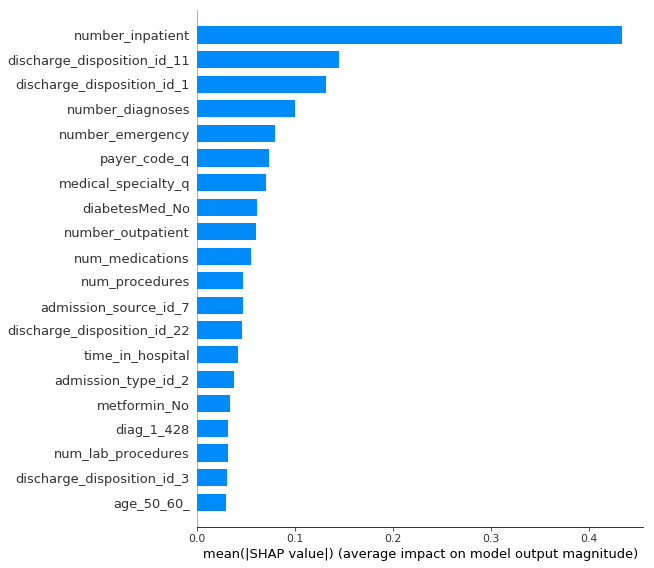

In [92]:
shap.summary_plot(shap_values[:, :-1], model.feature_names, plot_type="bar")

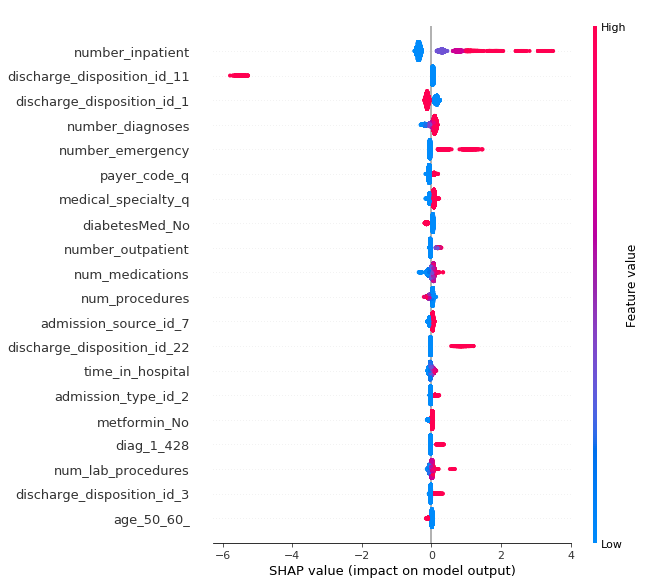

In [93]:
shap.summary_plot(shap_values[:, :-1], testdf[model.feature_names])

## Local explanation scripts below

In [94]:
def shap_localexplain(row):
    
    """ Summarize local Shapley information. 
    
    :param row: The row to explain from numpy array of Shapley values.
    
    """
    
    # select shapley values for row
    # reshape into column vector
    # convert to pandas dataframe for easy plotting
    s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(shap_values.shape[1]-1, 1), 
                        columns=['Approximate Local Contributions'],
                        index=model.feature_names) # must use feature_names for consistent results

    # sort dataframe by shapley values and print values
    s_df = s_df.sort_values(by='Approximate Local Contributions')
    #print(s_df, '\n')
    return s_df

    # plot top positive contributors for this row
    #_= s_df.iloc[-5:,:].plot(kind='bar', title='Approximate Local Contributions', legend=False)
    
    # manually calculate sum of shapley values for row
    #print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
    
    # manually calculate actual model prediction before application of logit link function
    #p = row['predict'].values[0]
    #print('Model prediction: ', np.log(p/(1 - p))) # inverse logit

In [80]:
#test['ID'] = np.arange(test.shape[0])
#test.reset_index(inplace=True)                 # create new sequential index for join directly below
#test.drop(['index'], inplace=True, axis=1)     # drop old index that came from when test set was sampled from entire data set

In [97]:
row1 = testdf_withID[testdf_withID['ID'] == 3706]
#row1
localexp_df = shap_localexplain(row1)
#localexp_df

## Model Scoring scripts below

In [98]:
def score(testdf):
    dtest = xgb.DMatrix(testdf)
    xgb_preds = pd.DataFrame(model.predict(dtest)) # score test set to find percentiles of predictions below
    return xgb_preds

In [99]:
#testing the score function
scores = score(testdf)
scores.head()

,0
0,0.125572
1,0.052470
2,0.150182
3,0.175052
4,0.191513


In [100]:
testdf.shape

(16221, 224)